# Average age
Average age of vehicles in the years covered by the inspection dataset. There is no data about time of vehicle destruction in the register dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 20

inspections_data_path = '../../../inspections/data/'


## Load data

In [2]:
from genericpath import exists


inspections_cols = [
    'VehicleType',
    'Date',
    'AgeDays',
]


def load_year(year):
    df_all = None

    for name in [f'{year}-{month:02}' for month in range(1, 13)]:
        # print(f'Load: {name}')
        if exists(f'{inspections_data_path}nosync/data_csv/{name}.csv'):
            df = pd.read_csv(f'{inspections_data_path}nosync/data_csv/{name}.csv',
                             usecols=inspections_cols, index_col=False)
            df['Date'] = pd.to_datetime(df['Date'])

        if df_all is None:
            df_all = df
        else:
            df_all = pd.concat([df_all, df])

    return df_all


years = [
    '2018',
    '2019',
    '2020',
    '2021',
    '2022'
]
dfs = {}

for year in years:
    print(year)
    
    df = load_year(year)
    df = df[df['VehicleType'] == 'OSOBNÍ AUTOMOBIL']
    dfs[year] = df


2018
2019
2020
2021
2022


In [3]:
dfs['2019'].head()

,Date,VehicleType,AgeDays
3,2019-01-14 07:37:22.723,OSOBNÍ AUTOMOBIL,10970
4,2019-01-29 10:58:24.557,OSOBNÍ AUTOMOBIL,6823
5,2019-01-31 05:56:00.390,OSOBNÍ AUTOMOBIL,6880
6,2019-01-10 11:23:41.817,OSOBNÍ AUTOMOBIL,6587
7,2019-01-15 09:34:57.943,OSOBNÍ AUTOMOBIL,8240


## Compute

In [4]:
df_stats = pd.DataFrame({'Year': years})
df_stats = df_stats.set_index('Year')

mean_ages = []
median_ages = []
for year, df in dfs.items():
    dfx = df[(df['Date'] >= f'{year}-01-01') & (df['Date'] < f'{int(year) + 1}-01-01')]
    mean_ages.append(dfx['AgeDays'].mean() / 365.25)
    median_ages.append(dfx['AgeDays'].median() / 365.25)

df_stats['Mean age'] = mean_ages
df_stats['Median age'] = median_ages

df_stats



,Mean age,Median age
Year,,
2018,12.340245,12.380561
2019,15.054461,15.167693
2020,15.625090,15.759069
2021,15.885407,16.013689
2022,16.381635,16.476386


## Plot

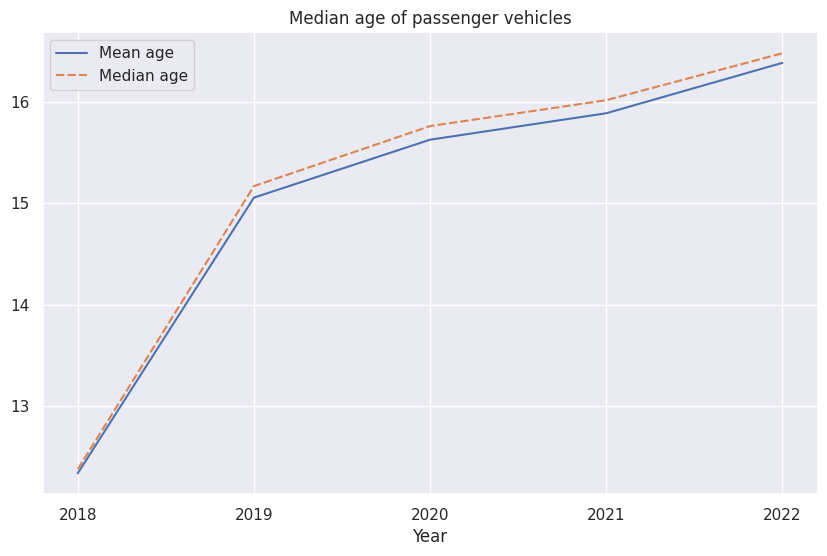

In [5]:
# sns.lineplot(y=df_stats['MedianAge'], x=years)
# sns.lineplot(y=df_stats['MeanAge'], x=years)
sns.lineplot(df_stats)
plt.title('Median age of passenger vehicles')
# plt.grid()
plt.show()

## Examine suspiciously low value in 2018

In [6]:
inspections_cols = [
    'VehicleType',
    
    'Date',
    'AgeDays',
]

,Date,VehicleType,AgeDays
0,2018-01-02 11:03:12.833,OSOBNÍ AUTOMOBIL,2518
1,2018-01-02 11:15:08.083,OSOBNÍ AUTOMOBIL,358
2,2018-01-02 11:30:25.420,OSOBNÍ AUTOMOBIL,2744
3,2018-01-02 11:26:50.967,OSOBNÍ AUTOMOBIL,1926
4,2018-01-02 12:11:56.770,OSOBNÍ AUTOMOBIL,2927


## Trend

### Basic prediction
Use ARMA to obtain a prediction.

In [41]:
df_stats['Median age']

Year
2018    12.380561
2019    15.167693
2020    15.759069
2021    16.013689
2022    16.476386
Name: Median age, dtype: float64

In [57]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(df_stats['Mean age'], order=(1, 0, 1), trend="n")
arma_res = arma_mod.fit()

/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/school/2023-2024_ls/dp/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/g

In [61]:
arma_res.predict(start=0, end=10)

2018-01-01     0.000000
2019-01-01    12.265984
2020-01-01    16.269821
2021-01-01    15.007950
2022-01-01    16.350567
2023-01-01    16.209368
2024-01-01    16.014418
2025-01-01    15.821813
2026-01-01    15.631525
2027-01-01    15.443525
2028-01-01    15.257786
Freq: AS-JAN, Name: predicted_mean, dtype: float64